In [ ]:
# !pip install wandb --upgrade
# !pip install keras

In [ ]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing relevant libraries
import numpy as np
from scipy import linalg as LA
import pandas as pd
import torch
import tensorflow as tf
import keras
import seaborn as sns
import matplotlib.pyplot as plt
from keras.datasets import mnist

from sklearn import metrics
from tqdm.auto import tqdm
import pprint

In [ ]:
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch import optim
import torch.nn as nn
from torch.autograd import Variable

In [ ]:
import time

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using', device)

Using cpu


In [ ]:
# Directories to store the models and plots
direc_main = './drive/MyDrive/Semester_7/Advanced_Signal_Processing/A3_AE/'
direc_pics = './drive/MyDrive/Semester_7/Advanced_Signal_Processing/A3_AE/pics/'

# Data Loading

## From Keras

In [ ]:
def loadMNIST(return_images=False, is_val_split=False, val_samples=10000, seed_value=0):
    '''
    ################
    Function which returns a dictionary containing the shuffled version of the MNIST dataset.
    Arguments:
    return_images   [bool]  Whether we need to return images            (default: False)
                                True: returns images
                                False: returns flattened vectors
    is_val_split    [bool]  Whether validation split needs to be done   (default: False)
                                True: returns train(60K-val_samples), validation(val_samples) and test(10K)
                                False: returns train(60K) and test(10K)
    val_samples     [int]   Number of validation samples to take out of the training set of 60K samples     (default: 10K)
    seed            [int]   Seed value for the numpy random shuffling   (default: 0)
    ########
    Return:
    Dictionary containing the numpy arrays corresponding to train, test and val(if is_val_split==True)
                    dict:   train:  X
                                    y
                            test:   X
                                    y
                            val:    X           (if is_val_split == True)
                                    y           (if is_val_split == True)
    ################
    '''

    # Loading MNIST data onto numpy arrays
    (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

    # Shuffling data
    np.random.seed(seed_value)
    train_shuffler = np.random.permutation(60000)
    x_train, y_train = x_train[train_shuffler], y_train[train_shuffler]
    test_shuffler = np.random.permutation(10000)
    x_test, y_test = x_test[test_shuffler], y_test[test_shuffler]

    # Normalizing the input data
    x_train = np.array(x_train/255.0, dtype='float32')
    x_test = np.array(x_test/255.0, dtype='float32')

    ## Splitting data appropriately
    # Number of training samples 
    train_samples = 60000 - val_samples

    if is_val_split == True:
        # Splitting the train set into the new train and val sets
        x_train, x_val = x_train[:train_samples], x_train[train_samples:]
        y_train, y_val = y_train[:train_samples], y_train[train_samples:]

        # Flattening the 28x28 images into vectors and then returning
        if (return_images==False):
            return {
                'train':{
                    'X': x_train.reshape([train_samples, 784]),
                    'Y': y_train.reshape([train_samples])
                },
                'val':{
                    'X': x_val.reshape([val_samples, 784]),
                    'Y': y_val.reshape([val_samples])
                },
                'test':{
                    'X': x_test.reshape([10000, 784]),
                    'Y': y_test.reshape([10000])
                }
            }
        # Returning the 28x28 images as is
        else :
            return {
                'train':{
                    'X': x_train,
                    'Y': y_train
                },
                'val':{
                    'X': x_val,
                    'Y': y_val
                },
                'test':{
                    'X': x_test,
                    'Y': y_test
                }
            }
    # Training set is not split
    else:
        # Flattening the images and then returning
        if (return_images==False):
            return {
                'train':{
                    'X': x_train.reshape([60000, 784]),
                    'Y': y_train.reshape([60000])
                },
                'test':{
                    'X': x_test.reshape([10000, 784]),
                    'Y': y_test.reshape([10000])
                }
            }
        # Returning the images as is
        else :
            return {
                'train':{
                    'X': x_train,
                    'Y': y_train
                },
                'test':{
                    'X': x_test,
                    'Y': y_test
                }
            }


In [ ]:
# Loading data as flattened vectors with no validation set
data = loadMNIST()

mean_train = np.mean(data['train']['X'], axis=0)
mean_test = np.mean(data['test']['X'], axis=0)
# Making a zero mean data set
data_zero = {
    'train': {
        'X': data['train']['X'] - mean_train,
        'Y': data['train']['Y']
    },
    'test': {
        'X': data['test']['X'] - mean_test,
        'Y': data['test']['Y']
    }
}

## Bringing Data Set into PyTorch

In [ ]:
# Initializing pytorch dataset from the numpy datasets we have so far
data_torch = {
    'train': {
        'X': torch.from_numpy(data['train']['X']),
        'Y': torch.from_numpy(data['train']['Y'])
    },
    'test': {
        'X': torch.from_numpy(data['test']['X']),
        'Y': torch.from_numpy(data['test']['Y'])
    }
}

data_torch_zero = {
    'train': {
        'X': torch.from_numpy(data_zero['train']['X']),
        'Y': torch.from_numpy(data_zero['train']['Y'])
    },
    'test': {
        'X': torch.from_numpy(data_zero['test']['X']),
        'Y': torch.from_numpy(data_zero['test']['Y'])
    }
}

train_data = torch.utils.data.TensorDataset(data_torch['train']['X'], data_torch['train']['Y'])
test_data = torch.utils.data.TensorDataset(data_torch['test']['X'], data_torch['test']['Y'])
train_data_zero = torch.utils.data.TensorDataset(data_torch_zero['train']['X'], data_torch_zero['train']['Y'])
test_data_zero = torch.utils.data.TensorDataset(data_torch_zero['test']['X'], data_torch_zero['test']['Y'])

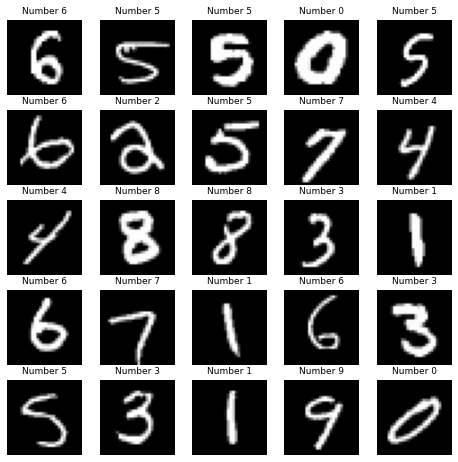

In [ ]:
# Plotting 25 random data points from the dataset to get an idea of the dataset
prefix = direc_pics + 'dset_'
figure = plt.figure(figsize=(8, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title('Number {}'.format(label), fontsize=9)
    plt.axis("off")
    plt.imshow(torch.reshape(img, (28,28)), cmap="gray")
plt.savefig(prefix + '25point.png',bbox_inches='tight')
plt.show()

In [ ]:
# Train has 600 batches of size 100. Test is just 1 batch of 10K as we only use it for testing.
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=10000, 
                                          shuffle=True, 
                                          num_workers=1),
}

# Training and Testing Functions

In [ ]:
def train_loop(loaders, model, loss_fn, optimizer, type='normal', lamb=1, interval=75):
    '''
    Function to train the model and log required information
    Arguments:
    loaders                 dict containing DataLoader objects for the data
    model                   The neural network we want to train
    loss_fn                 The loss function we are trying to minimize
    optimizer               Optimizer that we will use
    type                    Type of AE ('normal', 'sparse', 'denoising', 'contractive')
    lamb                    Lambda - The regularization parameter to control how much regularization to have
    interval                Interval between logging of loss & calculating test metrics [default: 75]
    Returns:    Dict containing lists of training losses and test losses.
    '''
    dataloader = loaders['train']
    size = len(dataloader.dataset)
    losses = []
    losses_test = []

    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        if type == 'denoising':
            Xn = X + lamb*torch.rand_like(X)
            temp = model(Xn)
        else:
            temp = model(X)

        loss = loss_fn(X, temp['out'])/X.shape[0]
        if type == 'sparse':
            loss += lamb*torch.mean(torch.norm(temp['h'], p=1, dim=1))
        losses.append(loss.item())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % interval == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"Loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            temp1 = test_loop(loaders, model, loss_fn, type, lamb)
            losses_test.append(temp1['loss'])
        
    return {
        'losses': losses,
        'losses_test': losses_test
    }


def test_loop(loaders, model, loss_fn, type='normal', lamb=1):
    '''
    Function to calculate loss and accuracy of the model on the test set.
    Arguments:
    loaders                 dict containing DataLoader objects for the data
    model                   The neural network we want to test
    loss_fn                 The loss function we are trying to minimize in training
    type                    Type of AE ('normal', 'sparse', 'denoising', 'contractive')
    lamb                    Lambda - The regularization parameter to control how much regularization to have
    Returns:    Dict containing loss and accuracy of the model on the test dataset
    '''
    dataloader = loaders['test']
    size = len(dataloader.dataset)
    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            temp = model(X)
            test_loss += loss_fn(temp['out'], X).item()
            if type == 'sparse':
                test_loss += lamb*(torch.sum(torch.norm(temp['h'], p=1, dim=1)).item())

    test_loss /= size
    print(f"Test Metrics: Avg loss = {test_loss:>8f} \n")

    return {
        'loss': test_loss
    }

In [ ]:
def train_loop_lite(loaders, model, loss_fn, optimizer, type='normal', lamb=1, interval=75):
    '''
    Function to train the model and log required information. This is just a lighter version without all the loss logging.
    Arguments:
    loaders                 dict containing DataLoader objects for the data
    model                   The neural network we want to train
    loss_fn                 The loss function we are trying to minimize
    optimizer               Optimizer that we will use
    type                    Type of AE ('normal', 'sparse', 'denoising', 'contractive')
    lamb                    Lambda - The regularization parameter to control how much regularization to have
    interval                Interval between logging of loss & calculating test metrics [default: 75]
    Returns:    None
    '''
    dataloader = loaders['train']
    size = len(dataloader.dataset)

    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        if type == 'denoising':
            Xn = X + lamb*torch.rand_like(X)
            temp = model(Xn)
        else:
            temp = model(X)
        loss = loss_fn(X, temp['out'])/X.shape[0]
        if type == 'sparse':
            loss += lamb*torch.mean(torch.norm(temp['h'], p=1, dim=1))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % interval == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"Loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            test_loop_lite(loaders, model, loss_fn, type, lamb)


def test_loop_lite(loaders, model, loss_fn, type='normal', lamb=1):
    '''
    Function to calculate loss and accuracy of the model on the test set. This is just a lighter version without all the loss logging.
    Arguments:
    loaders                 dict containing DataLoader objects for the data
    model                   The neural network we want to test
    loss_fn                 The loss function we are trying to minimize in training
    type                    Type of AE ('normal', 'sparse', 'denoising', 'contractive')
    lamb                    Lambda - The regularization parameter to control how much regularization to have
    Returns:    None
    '''
    dataloader = loaders['test']
    size = len(dataloader.dataset)
    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            temp = model(X)
            test_loss += loss_fn(temp['out'], X).item()
            if type == 'sparse':
                test_loss += lamb*(torch.sum(torch.norm(temp['h'], p=1, dim=1)).item())

    test_loss /= size
    print(f"Test Metrics: Avg loss = {test_loss:>8f} \n")


In [ ]:
def plotGraphs(losses, losses_test, interval, prefix=''):
    '''
    Function to do all the relevant plotting of losses vs iterations
    Arguments:
    losses          List containing loss on the training set every iteration
    losses_test     List containing loss on the test set every 'interval' iterations
    interval        Number of iterations between test set evaluations during training
    prefix          Prefix to be added to plot names when saving     (default: '')
    '''
    # Number of iterations carried out during training
    num_iters = len(losses)

    plt.figure()
    plt.plot(np.arange(num_iters), losses)
    plt.grid()
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Train Loss Plot')
    plt.savefig(prefix + '_train_loss.png',bbox_inches='tight')
    plt.show()

    plt.figure()
    plt.plot(list(np.arange(1, num_iters-1, interval)) + [num_iters], losses_test)
    plt.grid()
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Test Loss Plot')
    plt.savefig(prefix + '_test_loss.png',bbox_inches='tight')
    plt.show()


# Comparing PCA & AutoEncoders

## PCA

In [ ]:
def analysePCA(data, num_eigs):
    '''
    Function to perform PCA on given data and calculate reconstruction error using 'num_eigs' components
    Arguments:
    data            Dictionary containing the zero mean train and test data
    num_eigs        Number of comoponents used to calculate the reconstruction error
    Return:
    Dictionary containing the reconstruction error on the train and test data
    '''

    # Forming the covariance matrix for the data set and getting the required eigenvalues and vectors
    covar_train = np.cov(data['train']['X'], rowvar=False)
    evals, evecs = np.linalg.eigh(covar_train)
    evals = evals[-num_eigs:]
    evecs = evecs[:, -num_eigs:]

    # Generating the new PCA feature vectors
    data_PCA = {
        'train': {
            'X': data['train']['X']@evecs,
            'Y': data['train']['Y']
        },
        'test': {
            'X': data['test']['X']@evecs,
            'Y': data['test']['Y']
        }
    }
    # Reconstructing data
    data_recon = {
        'train': {
            'X': data_PCA['train']['X']@evecs.T,
            'Y': data_PCA['train']['Y']
        },
        'test': {
            'X': data_PCA['test']['X']@evecs.T,
            'Y': data_PCA['test']['Y']
        }
    }

    # Calculating reconstruction error
    train_error = np.square(np.linalg.norm(data_recon['train']['X']-data['train']['X'], ord='fro'))/data['train']['X'].shape[0]
    test_error = np.square(np.linalg.norm(data_recon['test']['X']-data['test']['X'], ord='fro'))/data['test']['X'].shape[0]

    return {
        'train': train_error,
        'test': test_error
    }

In [ ]:
# Number of eigen values we want to use for performing the PCA
num_eigs = 30

error = analysePCA(data, num_eigs)
print('PCA reconstruction error on Train Data: {}'.format(error['train']))
print('PCA reconstruction error on Test Data: {}'.format(error['test']))

PCA reconstruction error on Train Data: 14.470815571129425
PCA reconstruction error on Test Data: 14.12896611850214


## Linear AE with Squared Error

In [ ]:
# Class defining the AE model
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 512), 
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128), 
            nn.ReLU(),
            nn.Linear(128, 30), 
            nn.ReLU()            
        )
        self.decoder = nn.Sequential(
            nn.Linear(30, 128), 
            nn.ReLU(),
            nn.Linear(128, 256), 
            nn.ReLU(),
            nn.Linear(256, 784)
        )
        self.relu = nn.Sequential(
            nn.ReLU()
        )        
        
    def forward(self, X, output_active=True):
        h = self.encoder(X)
        Xhat = self.decoder(h)
        if output_active:
            Xhat = self.relu(Xhat)

        return {
            'h': h,
            'in': X,
            'out': Xhat
        }


In [ ]:
model = AE()
print(model)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=30, bias=True)
    (7): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=30, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=784, bias=True)
  )
  (relu): Sequential(
    (0): ReLU()
  )
)


In [ ]:
# MSE Loss
loss_fn = nn.MSELoss(reduction='sum')

# Adam optimizer
optimizer = optim.Adam(model.parameters())

# These many epochs seem to be enough for saturation.
num_epochs = 12

In [ ]:
# Warming up the compute for optimal time measurement
start = time.time()
temp1 = np.random.rand(3000, 2000)
temp2 = np.random.rand(2000, 1000)
temp1 = temp1@temp2
end = time.time()

# Measuring time taken for the training process
# losses = []
# losses_test = []

interval = 75
start = time.time()
for i in range(num_epochs):
    print(f"Epoch {i+1}\n-------------------------------")
    
    # Training the network for this epoch
    train_loop_lite(loaders, model, loss_fn, optimizer, 'normal', 1, interval)
    # losses += temp['losses']
    # losses_test += temp['losses_test']

test_loop_lite(loaders, model, loss_fn, 'normal', 1)
# losses_test.append(temp['loss'])
end = time.time()
print('Time taken for the training: {0:.5f} seconds'.format(end-start))


Epoch 1
-------------------------------
Loss: 80.919662  [    0/60000]
Test Metrics: Avg loss = 84.987700 

Loss: 57.218056  [ 7500/60000]
Test Metrics: Avg loss = 56.852100 

Loss: 41.632416  [15000/60000]
Test Metrics: Avg loss = 41.322566 

Loss: 36.096325  [22500/60000]
Test Metrics: Avg loss = 36.188191 

Loss: 32.979408  [30000/60000]
Test Metrics: Avg loss = 32.330434 

Loss: 28.977257  [37500/60000]
Test Metrics: Avg loss = 29.931041 

Loss: 29.213589  [45000/60000]
Test Metrics: Avg loss = 28.706809 

Loss: 28.205696  [52500/60000]
Test Metrics: Avg loss = 27.552953 

Epoch 2
-------------------------------
Loss: 26.176476  [    0/60000]
Test Metrics: Avg loss = 25.953647 

Loss: 25.416248  [ 7500/60000]
Test Metrics: Avg loss = 25.243244 

Loss: 26.017002  [15000/60000]
Test Metrics: Avg loss = 24.722767 

Loss: 24.180944  [22500/60000]
Test Metrics: Avg loss = 23.773906 

Loss: 25.001978  [30000/60000]
Test Metrics: Avg loss = 22.852636 

Loss: 23.083345  [37500/60000]
Test 

In [ ]:
# Reconstruction Accuracy on Train and Test Data
dataloader = loaders['train']
size = len(dataloader.dataset)
train_loss = 0
with torch.no_grad():
    for X, y in dataloader:
        temp = model(X)
        train_loss += loss_fn(temp['out'], X).item()
train_loss /= size
print(f"Reconstruction Error on Train Data = {train_loss}")

dataloader = loaders['test']
size = len(dataloader.dataset)
test_loss = 0
with torch.no_grad():
    for X, y in dataloader:
        temp = model(X)
        test_loss += loss_fn(temp['out'], X).item()
test_loss /= size
print(f"Reconstruction Error on Test Data = {test_loss}")

Reconstruction Error on Train Data = 16.140542584228516
Reconstruction Error on Test Data = 16.3870875


In [ ]:
# Saving the trained network
torch.save(model, direc_main+'baseline_model_final2.pth')

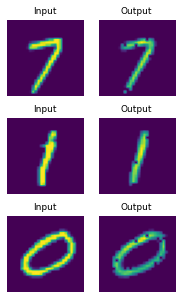

In [ ]:
prefix = direc_pics + 'Q1_'
cols, rows = 2, 3
for X, y in loaders['test']:
    Xhat = model(X)['out']
    figure = plt.figure(figsize=(3,1.7*rows))
    for i in range(1, rows + 1):
        figure.add_subplot(rows, cols, 2*i-1)
        plt.title('Input', fontsize=9)
        plt.axis("off")
        plt.imshow(torch.reshape(X[i], (28,28)).detach().numpy())
        figure.add_subplot(rows, cols, 2*i)
        plt.title('Output', fontsize=9)
        plt.axis("off")
        plt.imshow(torch.reshape(Xhat[i], (28,28)).detach().numpy())
    plt.savefig(prefix + '{}point.png'.format(rows),bbox_inches='tight')
    plt.show()
    break


# Experimenting with hidden units of varying sizes

## Quality of Reconstruction

In [ ]:
# Class defining the AE model
class AEshort(nn.Module):
    def __init__(self, N):
        super(AEshort, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, N), 
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(N, 784)
        )
        self.relu = nn.Sequential(
            nn.ReLU()
        )

    def forward(self, X, output_active=True):
        h = self.encoder(X)
        Xhat = self.decoder(h)
        if output_active:
            Xhat = self.relu(Xhat)

        return {
            'in': X,
            'out': Xhat,
            'h': h
        }


In [ ]:
model64 = AEshort(64)
model128 = AEshort(128)
model256 = AEshort(256)

In [ ]:
# MSE Loss
loss_fn = nn.MSELoss(reduction='sum')
# Number of Epochs
num_epochs = 8

In [ ]:
# Warming up the compute for optimal time measurement
start = time.time()
temp1 = np.random.rand(3000, 2000)
temp2 = np.random.rand(2000, 1000)
temp1 = temp1@temp2
end = time.time()

# Measuring time taken for the training process
model_dict = {64:model64, 128:model128, 256:model256}
interval = 75
for key in model_dict.keys():
    print('\nTraining the AE with size {} hidden layer:\n'.format(key))
    start = time.time()
    # Adam optimizer
    optimizer = optim.Adam(model_dict[key].parameters())
    for i in range(num_epochs):
        print(f"Epoch {i+1}\n-------------------------------")    
        # Training the network for this epoch
        train_loop_lite(loaders, model_dict[key], loss_fn, optimizer, 'normal', 1, interval)
    
    test_loop_lite(loaders, model_dict[key], loss_fn, 'normal', 1)
    end = time.time()
    print('----------------------------------------------------------------------')
    print('Time taken for the training: {0:.5f} seconds'.format(end-start))
    print('----------------------------------------------------------------------')
    print('----------------------------------------------------------------------')



Training the AE with size 64 hidden layer:

Epoch 1
-------------------------------
Loss: 80.162956  [    0/60000]
Test Metrics: Avg loss = 81.970613 

Loss: 31.801975  [ 7500/60000]
Test Metrics: Avg loss = 30.866284 

Loss: 21.716141  [15000/60000]
Test Metrics: Avg loss = 20.808809 

Loss: 17.945377  [22500/60000]
Test Metrics: Avg loss = 17.257700 

Loss: 15.437095  [30000/60000]
Test Metrics: Avg loss = 15.396636 

Loss: 15.115876  [37500/60000]
Test Metrics: Avg loss = 14.302900 

Loss: 14.372179  [45000/60000]
Test Metrics: Avg loss = 13.479875 

Loss: 12.740623  [52500/60000]
Test Metrics: Avg loss = 12.961759 

Epoch 2
-------------------------------
Loss: 13.206409  [    0/60000]
Test Metrics: Avg loss = 12.586123 

Loss: 12.012952  [ 7500/60000]
Test Metrics: Avg loss = 12.299964 

Loss: 12.747976  [15000/60000]
Test Metrics: Avg loss = 12.021509 

Loss: 11.303972  [22500/60000]
Test Metrics: Avg loss = 11.794156 

Loss: 11.684566  [30000/60000]
Test Metrics: Avg loss = 11.

In [ ]:
# Saving the trained network
for key in model_dict.keys():
    torch.save(model_dict[key], direc_main+'model_{}_final.pth'.format(key))

In [ ]:
for key in model_dict.keys():
    modelll = model_dict[key]
    print('\n Key: {}'.format(key))
    # Reconstruction Accuracy on Train and Test Data
    dataloader = loaders['train']
    size = len(dataloader.dataset)
    train_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            temp = modelll(X)
            train_loss += loss_fn(temp['out'], X).item()
    train_loss /= size
    print(f"Reconstruction Error on Train Data = {train_loss}")

    dataloader = loaders['test']
    size = len(dataloader.dataset)
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            temp = modelll(X)
            test_loss += loss_fn(temp['out'], X).item()
    test_loss /= size
    print(f"Reconstruction Error on Test Data = {test_loss}")


 Key: 64
Reconstruction Error on Train Data = 10.217166283162435
Reconstruction Error on Test Data = 10.10663515625

 Key: 128
Reconstruction Error on Train Data = 5.966484440104167
Reconstruction Error on Test Data = 5.922387109375

 Key: 256
Reconstruction Error on Train Data = 4.810898258972168
Reconstruction Error on Test Data = 4.774082421875


## Test Images and Non-Digit/Random Noise Images

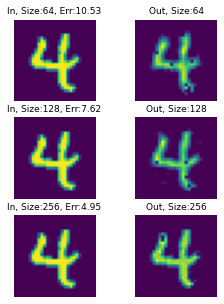

In [ ]:
prefix = direc_pics + 'Q2a_'
loss_dict = {}
cols, rows = 2, len(model_dict.keys())
for X, y in loaders['test']:
    count = 1
    figure = plt.figure(figsize=(4,1.7*rows))
    for key in model_dict.keys():
        modell = model_dict[key]
        Xhat = modell(X)['out']
        loss_dict[key] = loss_fn(X[0], Xhat[0])

        figure.add_subplot(rows, cols, 2*count-1)
        plt.title('In, Size:{0}, Err:{1:0.2f}'.format(key, loss_dict[key]), fontsize=9)
        plt.axis("off")
        plt.imshow(torch.reshape(X[0], (28,28)).detach().numpy())
        figure.add_subplot(rows, cols, 2*count)
        plt.title('Out, Size:{0}'.format(key), fontsize=9)
        plt.axis("off")
        plt.imshow(torch.reshape(Xhat[0], (28,28)).detach().numpy())
        count += 1
    plt.savefig(prefix + 'img.png',bbox_inches='tight')
    plt.show()
    break

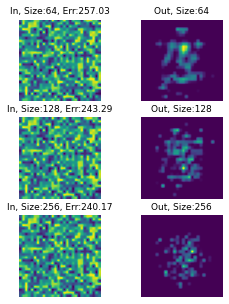

In [ ]:
# Randomly generated input for the AE
X = torch.rand(1,784)

prefix = direc_pics + 'Q2b_'
loss_dict = {}
cols, rows = 2, len(model_dict.keys())

count = 1
figure = plt.figure(figsize=(4,1.7*rows))
for key in model_dict.keys():
    modell = model_dict[key]
    Xhat = modell(X)['out']
    loss_dict[key] = loss_fn(X, Xhat)

    figure.add_subplot(rows, cols, 2*count-1)
    plt.title('In, Size:{0}, Err:{1:0.2f}'.format(key, loss_dict[key]), fontsize=9)
    plt.axis("off")
    plt.imshow(torch.reshape(X, (28,28)).detach().numpy())
    figure.add_subplot(rows, cols, 2*count)
    plt.title('Out, Size:{0}'.format(key), fontsize=9)
    plt.axis("off")
    plt.imshow(torch.reshape(Xhat, (28,28)).detach().numpy())
    count += 1
plt.savefig(prefix + 'img.png',bbox_inches='tight')
plt.show()


# Sparse AutoEncoders

In [ ]:
# Class defining the sparse AE model
class AEsparse(nn.Module):
    def __init__(self, N=900):
        super(AEsparse, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, N), 
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(N, 784)
        )
        self.relu = nn.Sequential(
            nn.ReLU()
        )

    def forward(self, X, output_active=True):
        h = self.encoder(X)
        Xhat = self.decoder(h)
        if output_active:
            Xhat = self.relu(Xhat)

        return {
            'in': X,
            'out': Xhat,
            'h': h
        }

In [ ]:
N = 36**2
model_sp = AEsparse(N)
model_sp

AEsparse(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=1296, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=1296, out_features=784, bias=True)
  )
  (relu): Sequential(
    (0): ReLU()
  )
)

In [ ]:
loss_fn = nn.MSELoss(reduction='sum')   
optimizer = optim.Adam(model_sp.parameters())
num_epochs = 8

In [ ]:
# Warming up the compute for optimal time measurement
start = time.time()
temp1 = np.random.rand(3000, 2000)
temp2 = np.random.rand(2000, 1000)
temp1 = temp1@temp2
end = time.time()

# Measuring time taken for the training process
interval = 75
lamb = 1e-1
print('\nTraining the AE with size {} hidden layer:'.format(N))
start = time.time()
for i in range(num_epochs):
    print(f"Epoch {i+1}\n-------------------------------")    
    # Training the network for this epoch
    train_loop_lite(loaders, model_sp, loss_fn, optimizer, 'sparse', lamb, interval)

test_loop_lite(loaders, model_sp, loss_fn, 'sparse', lamb)
end = time.time()
print('----------------------------------------------------------------------')
print('Time taken for the training: {0:.5f} seconds'.format(end-start))
print('----------------------------------------------------------------------')
print('----------------------------------------------------------------------')



Training the AE with size 1296 hidden layer:
Epoch 1
-------------------------------
Loss: 92.061752  [    0/60000]
Test Metrics: Avg loss = 78.470354 

Loss: 19.230589  [ 7500/60000]
Test Metrics: Avg loss = 19.650858 

Loss: 15.008261  [15000/60000]
Test Metrics: Avg loss = 14.706872 

Loss: 12.661640  [22500/60000]
Test Metrics: Avg loss = 12.711663 

Loss: 10.947279  [30000/60000]
Test Metrics: Avg loss = 11.708593 

Loss: 10.950932  [37500/60000]
Test Metrics: Avg loss = 11.009969 

Loss: 9.627879  [45000/60000]
Test Metrics: Avg loss = 10.565461 

Loss: 10.439767  [52500/60000]
Test Metrics: Avg loss = 10.173336 

Epoch 2
-------------------------------
Loss: 9.578033  [    0/60000]
Test Metrics: Avg loss = 9.932973 

Loss: 9.002602  [ 7500/60000]
Test Metrics: Avg loss = 9.682049 

Loss: 9.605780  [15000/60000]
Test Metrics: Avg loss = 9.492274 

Loss: 9.754541  [22500/60000]
Test Metrics: Avg loss = 9.365853 

Loss: 9.605516  [30000/60000]
Test Metrics: Avg loss = 9.184325 

L

In [ ]:
# Reconstruction Accuracy on Train and Test Data
dataloader = loaders['train']
size = len(dataloader.dataset)
train_loss = 0
with torch.no_grad():
    for X, y in dataloader:
        temp = model_sp(X)
        train_loss += loss_fn(temp['out'], X).item()
train_loss /= size
print(f"Reconstruction Error on Train Data = {train_loss}")

dataloader = loaders['test']
size = len(dataloader.dataset)
test_loss = 0
with torch.no_grad():
    for X, y in dataloader:
        temp = model_sp(X)
        test_loss += loss_fn(temp['out'], X).item()
test_loss /= size
print(f"Reconstruction Error on Test Data = {test_loss}")

Reconstruction Error on Train Data = 4.694190864054362
Reconstruction Error on Test Data = 4.75546171875


In [ ]:
# Saving the trained network
torch.save(model_sp, direc_main+'model_sp_{}_final.pth'.format(N))

## Q3a

In [ ]:
dataloader = loaders['train']
size = len(dataloader.dataset)
activ_sp = 0
activ256 = 0
with torch.no_grad():
    for X, y in dataloader:
        temp = model_sp(X)
        activ_sp += torch.sum(torch.norm(temp['h'], p=1, dim=1)).item()
        temp = model256(X)
        activ256 += torch.sum(torch.norm(temp['h'], p=1, dim=1)).item()
activ256 /= size
activ_sp /= size

print(f"Average L1 norm of hidden layer activation(sparse) = {activ_sp}")
print(f"Average L1 norm of hidden layer activation(standard) = {activ256}")
print(f"Average L1 norm of hidden layer activation(sparse) per neuron = {activ_sp/N}")
print(f"Average L1 norm of hidden layer activation(standard) per neuron = {activ256/256}")

Average L1 norm of hidden layer activation(sparse) = 17.49965016072591
Average L1 norm of hidden layer activation(standard) = 188.67882805989584
Average L1 norm of hidden layer activation(sparse) per neuron = 0.013502816482041597
Average L1 norm of hidden layer activation(standard) per neuron = 0.7370266721089681


## Q3b

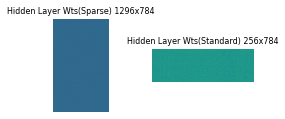

In [ ]:
prefix = direc_pics + 'Q3b_'
cols, rows = 2, 1
figure = plt.figure(figsize=(4,1.7*rows))

figure.add_subplot(rows, cols, 1)
plt.title('Hidden Layer Wts(Sparse) {}x784'.format(N), fontsize=8)
plt.axis("off")
plt.imshow(model_sp.state_dict()['encoder.0.weight'].detach().numpy())

figure.add_subplot(rows, cols, 2)
plt.title('Hidden Layer Wts(Standard) 256x784', fontsize=8)
plt.axis("off")
plt.imshow(model256.state_dict()['encoder.0.weight'].detach().numpy())

plt.savefig(prefix + 'whole.png',bbox_inches='tight')
plt.show()

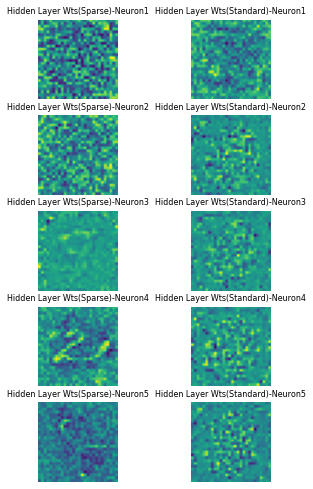

In [ ]:
cols, rows = 2, 5
figure = plt.figure(figsize=(5,1.7*rows))
for i in range(rows):
    figure.add_subplot(rows, cols, 2*i+1)
    plt.title('Hidden Layer Wts(Sparse)-Neuron{}'.format(i+1), fontsize=8)
    plt.axis("off")
    plt.imshow(torch.reshape(model_sp.state_dict()['encoder.0.weight'][i,:], (28,28)).detach().numpy())

    figure.add_subplot(rows, cols, 2*i+2)
    plt.title('Hidden Layer Wts(Standard)-Neuron{}'.format(i+1), fontsize=8)
    plt.axis("off")
    plt.imshow(torch.reshape(model256.state_dict()['encoder.0.weight'][i,:], (28,28)).detach().numpy())

plt.savefig(prefix + 'individual.png',bbox_inches='tight')
plt.show()

# Denoising AutoEncoders

In [ ]:
# Class defining the AE model
class AEnoisy(nn.Module):
    def __init__(self, N):
        super(AEnoisy, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, N), 
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(N, 784)
        )
        self.relu = nn.Sequential(
            nn.ReLU()
        )

    def forward(self, X, output_active=True):
        h = self.encoder(X)
        Xhat = self.decoder(h)
        if output_active:
            Xhat = self.relu(Xhat)
        return {
            'in': X,
            'out': Xhat,
            'h': h
        }


In [ ]:
# Noisy AE with 256 hidden neurons
N = 256
model_noisy = AEnoisy(N)
print(model_noisy)

loss_fn = nn.MSELoss(reduction='sum')   
optimizer = optim.Adam(model_noisy.parameters())
num_epochs = 8

AEnoisy(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=256, out_features=784, bias=True)
  )
  (relu): Sequential(
    (0): ReLU()
  )
)


In [ ]:
# Measuring time taken for the training process
interval = 75
lamb = 1e-1
print('\nTraining the AE with size {} hidden layer:'.format(N))
start = time.time()
for i in range(num_epochs):
    print(f"Epoch {i+1}\n-------------------------------")    
    # Training the network for this epoch
    train_loop_lite(loaders, model_noisy, loss_fn, optimizer, 'denoising', lamb, interval)

test_loop_lite(loaders, model_noisy, loss_fn, 'denoising', lamb)
end = time.time()
print('----------------------------------------------------------------------')
print('Time taken for the training: {0:.5f} seconds'.format(end-start))
print('----------------------------------------------------------------------')
print('----------------------------------------------------------------------')


Training the AE with size 256 hidden layer:
Epoch 1
-------------------------------
Loss: 83.207970  [    0/60000]
Test Metrics: Avg loss = 79.290531 

Loss: 20.031145  [ 7500/60000]
Test Metrics: Avg loss = 19.252866 

Loss: 13.428676  [15000/60000]
Test Metrics: Avg loss = 13.509216 

Loss: 11.629609  [22500/60000]
Test Metrics: Avg loss = 11.915012 

Loss: 10.178703  [30000/60000]
Test Metrics: Avg loss = 11.104246 

Loss: 9.808058  [37500/60000]
Test Metrics: Avg loss = 10.683494 

Loss: 8.996325  [45000/60000]
Test Metrics: Avg loss = 10.333134 

Loss: 8.708858  [52500/60000]
Test Metrics: Avg loss = 9.880998 

Epoch 2
-------------------------------
Loss: 7.958359  [    0/60000]
Test Metrics: Avg loss = 9.643838 

Loss: 8.555544  [ 7500/60000]
Test Metrics: Avg loss = 9.334302 

Loss: 8.833705  [15000/60000]
Test Metrics: Avg loss = 9.162086 

Loss: 6.969676  [22500/60000]
Test Metrics: Avg loss = 8.951118 

Loss: 7.514245  [30000/60000]
Test Metrics: Avg loss = 8.806900 

Loss:

In [ ]:
# Loading the standard model with 256 hidden neurons
model256 = torch.load(direc_main + 'model_256_final.pth')

In [ ]:
# Reconstruction Accuracy on Train and Test Data
dataloader = loaders['train']
size = len(dataloader.dataset)
train_loss = 0
with torch.no_grad():
    for X, y in dataloader:
        temp = model_noisy(X)
        train_loss += loss_fn(temp['out'], X).item()
train_loss /= size
print(f"Reconstruction Error on Train Data = {train_loss}")

dataloader = loaders['test']
size = len(dataloader.dataset)
test_loss = 0
with torch.no_grad():
    for X, y in dataloader:
        temp = model_noisy(X)
        test_loss += loss_fn(temp['out'], X).item()
test_loss /= size
print(f"Reconstruction Error on Test Data = {test_loss}")

Reconstruction Error on Train Data = 8.801055633544921
Reconstruction Error on Test Data = 8.7461265625


## Q4a

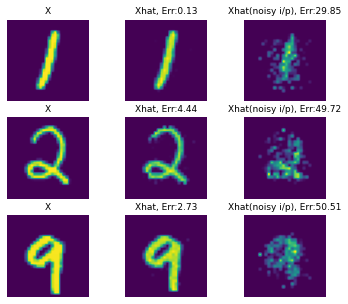

In [ ]:
numImages = 3
prefix = direc_pics + 'Q4a_'
cols, rows = 3, numImages

figure = plt.figure(figsize=(6,1.7*rows))
for X, y in loaders['test']:
    for i in range(numImages):
        Xhat = model256(X[i:i+1,:])['out']
        loss = loss_fn(X[i:i+1,:], Xhat).item()
        Xn = X[i:i+1,:] + torch.rand_like(X[i:i+1,:])
        Xhatn = model256(Xn)['out']
        lossn = loss_fn(X[i:i+1,:], Xhatn).item()        

        figure.add_subplot(rows, cols, 3*i+1)
        plt.title('X', fontsize=9)
        plt.axis("off")
        plt.imshow(torch.reshape(X[i,:], (28,28)).detach().numpy())
        
        figure.add_subplot(rows, cols, 3*i+2)
        plt.title('Xhat, Err:{0:.2f}'.format(loss), fontsize=9)
        plt.axis("off")
        plt.imshow(torch.reshape(Xhat, (28,28)).detach().numpy())
        
        figure.add_subplot(rows, cols, 3*i+3)
        plt.title('Xhat(noisy i/p), Err:{0:.2f}'.format(lossn), fontsize=9)
        plt.axis("off")
        plt.imshow(torch.reshape(Xhatn, (28,28)).detach().numpy())
    plt.savefig(prefix + 'img.png',bbox_inches='tight')
    plt.show()
    break


## Q4b

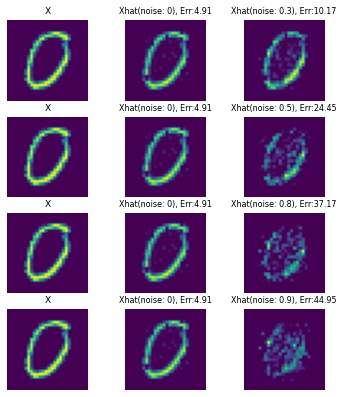

In [ ]:
prefix = direc_pics + 'Q4b_'
noise_vals = [0.3, 0.5, 0.8, 0.9]
cols, rows = 3, len(noise_vals)

count = 1
figure = plt.figure(figsize=(6,1.7*rows))
for X, y in loaders['test']:
    X = X[0:1,:]
    Xhat = model256(X)['out']
    loss = loss_fn(X, Xhat).item()
    for noise in noise_vals:
        Xn = X + noise*torch.rand_like(X)
        Xhatn = model256(Xn)['out']
        lossn = loss_fn(X, Xhatn).item()        

        figure.add_subplot(rows, cols, 3*count-2)
        plt.title('X', fontsize=9)
        plt.axis("off")
        plt.imshow(torch.reshape(X, (28,28)).detach().numpy())
        
        figure.add_subplot(rows, cols, 3*count-1)
        plt.title('Xhat(noise: 0), Err:{0:.2f}'.format(loss), fontsize=8)
        plt.axis("off")
        plt.imshow(torch.reshape(Xhat, (28,28)).detach().numpy())
        
        figure.add_subplot(rows, cols, 3*count)
        plt.title('Xhat(noise: {1}), Err:{0:.2f}'.format(lossn, noise), fontsize=8)
        plt.axis("off")
        plt.imshow(torch.reshape(Xhatn, (28,28)).detach().numpy())
        count += 1

    plt.savefig(prefix + 'img.png',bbox_inches='tight')
    plt.show()
    break

## Q4c

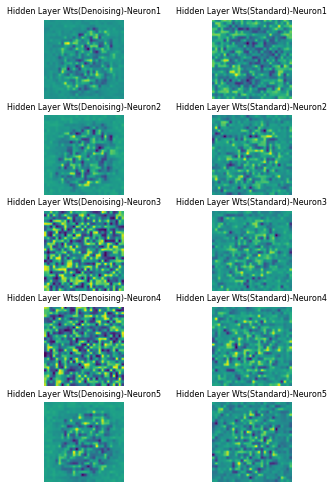

In [ ]:
prefix = direc_pics + 'Q4c_'
cols, rows = 2, 5
figure = plt.figure(figsize=(5.5,1.7*rows))

for i in range(rows):
    figure.add_subplot(rows, cols, 2*i+1)
    plt.title('Hidden Layer Wts(Denoising)-Neuron{}'.format(i+1), fontsize=8)
    plt.axis("off")
    plt.imshow(torch.reshape(model_noisy.state_dict()['encoder.0.weight'][i,:], (28,28)).detach().numpy())

    figure.add_subplot(rows, cols, 2*i+2)
    plt.title('Hidden Layer Wts(Standard)-Neuron{}'.format(i+1), fontsize=8)
    plt.axis("off")
    plt.imshow(torch.reshape(model256.state_dict()['encoder.0.weight'][i,:], (28,28)).detach().numpy())

plt.savefig(prefix + 'individual.png',bbox_inches='tight')
plt.show()

# Manifold Learning

## Q5a

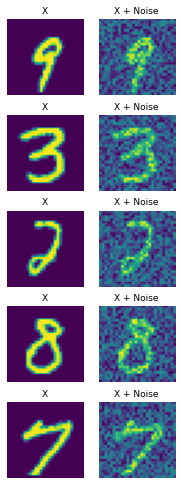

In [ ]:
prefix = direc_pics + 'Q5a_'
cols,rows = 2,5
figure = plt.figure(figsize=(3,1.7*rows))

for X, y in loaders['train']:
    for i in range(rows):
        img = X[i, :]
        Xn = img + torch.rand_like(img)

        figure.add_subplot(rows, cols, 2*i+1)
        plt.title('X', fontsize=9)
        plt.axis("off")
        plt.imshow(torch.reshape(img, (28,28)).detach().numpy())

        figure.add_subplot(rows, cols, 2*i+2)
        plt.title('X + Noise', fontsize=9)
        plt.axis("off")
        plt.imshow(torch.reshape(Xn, (28,28)).detach().numpy())

    plt.savefig(prefix + 'img.png',bbox_inches='tight')
    plt.show()

    break

## Q5b

In [ ]:
# Class defining the AE model
class AEman(nn.Module):
    def __init__(self):
        super(AEman, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 64), 
            nn.ReLU(),
            nn.Linear(64, 8),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 64), 
            nn.ReLU(),
            nn.Linear(64, 784)
        )
        self.relu = nn.Sequential(
            nn.ReLU()
        )        
        
    def forward(self, X, output_active=True):
        h = self.encoder(X)
        Xhat = self.decoder(h)
        if output_active:
            Xhat = self.relu(Xhat)

        return {
            'h': h,
            'in': X,
            'out': Xhat
        }

    def encode(self, X):
        h = self.encoder(X)

        return {
            'in': X,
            'out': h
        }

    def decode(self, h, output_active=True):
        Xhat = self.decoder(h)
        if output_active:
            Xhat = self.relu(Xhat)

        return {
            'in': h,
            'out': Xhat
        }


In [ ]:
model_man = AEman()
print(model_man)

# Loss function, optimizer and number of epochs
num_epochs = 8
loss_fn = nn.MSELoss(reduction='sum')   
optimizer = optim.Adam(model_man.parameters())

AEman(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=8, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=784, bias=True)
  )
  (relu): Sequential(
    (0): ReLU()
  )
)


In [ ]:
# Warming up the compute for optimal time measurement
start = time.time()
temp1 = np.random.rand(3000, 2000)
temp2 = np.random.rand(2000, 1000)
temp1 = temp1@temp2
end = time.time()

# Measuring time taken for the training process
interval = 75
lamb = 1e-1
print('\nTraining the AE:')
start = time.time()
for i in range(num_epochs):
    print(f"Epoch {i+1}\n-------------------------------")    
    # Training the network for this epoch
    train_loop_lite(loaders, model_man, loss_fn, optimizer, 'normal', lamb, interval)

test_loop_lite(loaders, model_man, loss_fn, 'normal', lamb)
end = time.time()
print('----------------------------------------------------------------------')
print('Time taken for the training: {0:.5f} seconds'.format(end-start))
print('----------------------------------------------------------------------')
print('----------------------------------------------------------------------')


Training the AE:
Epoch 1
-------------------------------
Loss: 87.457687  [    0/60000]
Test Metrics: Avg loss = 84.006850 

Loss: 57.745815  [ 7500/60000]
Test Metrics: Avg loss = 56.635106 

Loss: 48.745777  [15000/60000]
Test Metrics: Avg loss = 49.385119 

Loss: 46.860329  [22500/60000]
Test Metrics: Avg loss = 45.856050 

Loss: 44.259457  [30000/60000]
Test Metrics: Avg loss = 44.378906 

Loss: 43.592037  [37500/60000]
Test Metrics: Avg loss = 43.327475 

Loss: 43.254032  [45000/60000]
Test Metrics: Avg loss = 42.724475 

Loss: 43.318302  [52500/60000]
Test Metrics: Avg loss = 41.830616 

Epoch 2
-------------------------------
Loss: 42.154415  [    0/60000]
Test Metrics: Avg loss = 41.166787 

Loss: 41.443050  [ 7500/60000]
Test Metrics: Avg loss = 40.901781 

Loss: 41.853779  [15000/60000]
Test Metrics: Avg loss = 40.377375 

Loss: 38.333256  [22500/60000]
Test Metrics: Avg loss = 39.997028 

Loss: 37.118031  [30000/60000]
Test Metrics: Avg loss = 39.631603 

Loss: 39.893654  [

In [ ]:
# Saving the trained network
torch.save(model_man, direc_main+'model_man_final.pth')

In [ ]:
# Reconstruction Accuracy on Train and Test Data
dataloader = loaders['train']
size = len(dataloader.dataset)
train_loss = 0
with torch.no_grad():
    for X, y in dataloader:
        temp = model_man(X)
        train_loss += loss_fn(temp['out'], X).item()
train_loss /= size
print(f"Reconstruction Error on Train Data = {train_loss}")

dataloader = loaders['test']
size = len(dataloader.dataset)
test_loss = 0
with torch.no_grad():
    for X, y in dataloader:
        temp = model_man(X)
        test_loss += loss_fn(temp['out'], X).item()
test_loss /= size
print(f"Reconstruction Error on Test Data = {test_loss}")

Reconstruction Error on Train Data = 36.48774411621094
Reconstruction Error on Test Data = 36.65864375


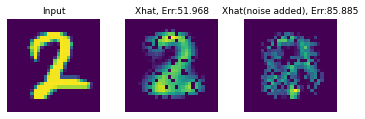

In [ ]:
prefix = direc_pics + 'Q5b_'
cols, rows = 3,1
figure = plt.figure(figsize=(6,1.7*rows))

for X, y in loaders['test']:
    X = X[0:1, :]
    h = model_man.encode(X)['out']
    hn = h + torch.randn_like(h)
    Xhatn = model_man.decode(hn)['out']
    lossn = loss_fn(X, Xhatn).item()
    Xhat = model_man.decode(h)['out']
    loss = loss_fn(X, Xhat).item()

    figure.add_subplot(rows, cols, 1)
    plt.title('Input', fontsize=9)
    plt.axis("off")
    plt.imshow(torch.reshape(X, (28,28)).detach().numpy())

    figure.add_subplot(rows, cols, 2)
    plt.title(f'Xhat, Err:{loss:.3f}', fontsize=9)
    plt.axis("off")
    plt.imshow(torch.reshape(Xhat, (28,28)).detach().numpy())

    figure.add_subplot(rows, cols, 3)
    plt.title(f'Xhat(noise added), Err:{lossn:.3f}', fontsize=9)
    plt.axis("off")
    plt.imshow(torch.reshape(Xhatn, (28,28)).detach().numpy())

    plt.savefig(prefix + 'img.png',bbox_inches='tight')
    plt.show()
    break

# Convolutional AutoEncoders

In [ ]:
# Loading data as images with no validation set
data_img = loadMNIST(True)

# Initializing pytorch dataset from the numpy datasets we have so far
data_torch_img = {
    'train': {
        'X': torch.from_numpy(np.expand_dims(data_img['train']['X'], axis=1)),
        'Y': torch.from_numpy(data_img['train']['Y'])
    },
    'test': {
        'X': torch.from_numpy(np.expand_dims(data_img['test']['X'], axis=1)),
        'Y': torch.from_numpy(data_img['test']['Y'])
    }
}

train_data_img = torch.utils.data.TensorDataset(data_torch_img['train']['X'], data_torch_img['train']['Y'])
test_data_img = torch.utils.data.TensorDataset(data_torch_img['test']['X'], data_torch_img['test']['Y'])

# Train has 600 batches of size 100. Test is just 1 batch of 10K as we only use it for testing.
loaders_img = {
    'train' : torch.utils.data.DataLoader(train_data_img, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data_img, 
                                          batch_size=10000, 
                                          shuffle=True, 
                                          num_workers=1),
}


In [ ]:
class AEconv1(nn.Module):
    '''
    Class to define the Convolutional AE with a MaxUnpooling & Deconvolutional decoder
    '''    
    def __init__(self):
        super(AEconv1, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1,8,3, stride=1, padding=1), 
            nn.ReLU())
        self.conv2 = nn.Sequential(
            nn.Conv2d(8,16,3, stride=1, padding=1),
            nn.ReLU())
        self.conv3 = nn.Sequential(
            nn.Conv2d(16,16,3, stride=1, padding=1),
            nn.ReLU())
        self.mp1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.mp2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.mp3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.ump1 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.ump2 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.ump3 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(16,16,3, stride=1, padding=1), 
            nn.ReLU())
        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(16,8,3, stride=1, padding=1),
            nn.ReLU())
        self.deconv3 = nn.Sequential(
            nn.ConvTranspose2d(8,1,3, stride=1, padding=1),
            nn.ReLU())
        self.output = nn.Sequential(nn.Conv2d(1,1,3, stride=1, padding=1), nn.ReLU())

    def forward(self, In):
        # print(In.shape)
        X = self.conv1(In)
        # print(X.shape)
        X, indices1 = self.mp1(X)
        # print(X.shape)
        X = self.conv2(X)
        # print(X.shape)
        X, indices2 = self.mp2(X)
        # print(X.shape)
        X = self.conv3(X)
        # print(X.shape)
        shap = X.shape
        h, indices3 = self.mp3(X)
        # print(h.shape)
        Xhat = self.ump1(h, indices3, output_size=shap)
        # print(Xhat.shape)
        Xhat = self.deconv1(Xhat)
        # print(Xhat.shape)
        Xhat = self.ump2(Xhat, indices2)
        # print(Xhat.shape)
        Xhat = self.deconv2(Xhat)
        # print(Xhat.shape)
        Xhat = self.ump3(Xhat, indices1)
        # print(Xhat.shape)
        Xhat = self.deconv3(Xhat)
        # print(Xhat.shape)
        Xhat = self.output(Xhat)
        # print(Xhat.shape)

        return {
            'h': h,
            'in': In,
            'out': Xhat
        }


In [ ]:
class AEconv2(nn.Module):
    '''
    Class to define the Convolutional AE with a purely MaxUnpooling decoder
    '''
    def __init__(self):
        super(AEconv2, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1,8,3, stride=1, padding=1), 
            nn.ReLU())
        self.conv2 = nn.Sequential(
            nn.Conv2d(8,16,3, stride=1, padding=1),
            nn.ReLU())
        self.conv3 = nn.Sequential(
            nn.Conv2d(16,16,3, stride=1, padding=1),
            nn.ReLU())
        self.mp1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.mp2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.mp3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.ump1 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.ump2 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.ump3 = nn.MaxUnpool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Sequential(
            nn.Conv2d(16,16,3, stride=1, padding=1), 
            nn.ReLU())
        self.conv5 = nn.Sequential(
            nn.Conv2d(16,8,3, stride=1, padding=1),
            nn.ReLU())
        self.conv6 = nn.Sequential(
            nn.Conv2d(8,1,3, stride=1, padding=1),
            nn.ReLU())
        self.output = nn.Sequential(nn.Conv2d(1,1,3, stride=1, padding=1), nn.ReLU())

    def forward(self, In):
        # print(In.shape)
        X = self.conv1(In)
        # print(X.shape)
        X, indices1 = self.mp1(X)
        # print(X.shape)
        X = self.conv2(X)
        # print(X.shape)
        X, indices2 = self.mp2(X)
        # print(X.shape)
        X = self.conv3(X)
        # print(X.shape)
        shap = X.shape
        h, indices3 = self.mp3(X)
        # print(h.shape)
        Xhat = self.ump1(h, indices3, output_size=shap)
        # print(Xhat.shape)
        Xhat = self.conv4(Xhat)
        # print(Xhat.shape)
        Xhat = self.ump2(Xhat, indices2)
        # print(Xhat.shape)
        Xhat = self.conv5(Xhat)
        # print(Xhat.shape)
        Xhat = self.ump3(Xhat, indices1)
        # print(Xhat.shape)
        Xhat = self.conv6(Xhat)
        # print(Xhat.shape)
        Xhat = self.output(Xhat)
        # print(Xhat.shape)

        return {
            'h': h,
            'in': In,
            'out': Xhat
        }


In [ ]:
class AEconv3(nn.Module):
    '''
    Class to define the Convolutional AE with a purely Deconvolutional decoder
    '''    
    def __init__(self):
        super(AEconv3, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1,8,3, stride=1, padding=1), 
            nn.ReLU())
        self.conv2 = nn.Sequential(
            nn.Conv2d(8,16,3, stride=1, padding=1),
            nn.ReLU())
        self.conv3 = nn.Sequential(
            nn.Conv2d(16,16,3, stride=1, padding=1),
            nn.ReLU())
        self.mp1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.mp2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.mp3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(16,16,5), 
            nn.ReLU())
        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(16,8,5, stride=2, padding=2, output_padding=1),
            nn.ReLU())
        self.deconv3 = nn.Sequential(
            nn.ConvTranspose2d(8,1,4, stride=2, padding=1),
            nn.ReLU())
        self.output = nn.Sequential(nn.Conv2d(1,1,3, stride=1, padding=1), nn.ReLU())

    def forward(self, In):
        # X = self.conv1(In)
        # X = self.mp1(X)
        # X = self.conv2(X)
        # X = self.mp2(X)
        # X = self.conv3(X)
        # h = self.mp3(X)

        # print(In.shape)
        X = self.conv1(In)
        # print(X.shape)
        X = self.mp1(X)
        # print(X.shape)
        X = self.conv2(X)
        # print(X.shape)
        X = self.mp2(X)
        # print(X.shape)
        X = self.conv3(X)
        # print(X.shape)
        shap = X.shape
        h = self.mp3(X)
        # print(h.shape)

        Xhat = self.deconv1(h)
        # print(Xhat.shape)
        Xhat = self.deconv2(Xhat)
        # print(Xhat.shape)
        Xhat = self.deconv3(Xhat)
        # print(Xhat.shape)
        Xhat = self.output(Xhat)
        # print(Xhat.shape)

        return {
            'h': h,
            'in': In,
            'out': Xhat
        }


In [ ]:
losses_dict = {}
losses_test_dict = {}

## Training Model with Deconv and Unpooling Layers

In [ ]:
modelc1 = AEconv1()
print(modelc1)

# Loss function, optimizer and number of epochs
num_epochs = 8
loss_fn = nn.MSELoss(reduction='sum')   
optimizer = optim.Adam(modelc1.parameters())

AEconv1(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (mp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (mp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (mp3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (ump1): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (ump2): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (ump3): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (deconv1): Sequential(
    (0): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (deconv2): Sequential(
    (0): ConvTr

In [ ]:
# Warming up the compute for optimal time measurement
start = time.time()
temp1 = np.random.rand(3000, 2000)
temp2 = np.random.rand(2000, 1000)
temp1 = temp1@temp2
end = time.time()

# Measuring time taken for the training process
interval = 75
lamb = 1e-1
losses = []
losses_test = []

print('\nTraining the AE:')
start = time.time()
for i in range(num_epochs):
    print(f"Epoch {i+1}\n-------------------------------")    
    # Training the network for this epoch
    temp = train_loop(loaders_img, modelc1, loss_fn, optimizer, 'normal', lamb, interval)
    losses += temp['losses']
    losses_test += temp['losses_test']

temp = test_loop(loaders_img, modelc1, loss_fn, 'normal', lamb)
losses_test.append(temp['loss'])
end = time.time()
losses_dict['c1'] = losses
losses_test_dict['c1'] = losses_test

print('----------------------------------------------------------------------')
print('Time taken for the training: {0:.5f} seconds'.format(end-start))
print('----------------------------------------------------------------------')
print('----------------------------------------------------------------------')


Training the AE:
Epoch 1
-------------------------------
Loss: 84.880959  [    0/60000]
Test Metrics: Avg loss = 85.472262 

Loss: 51.611015  [ 7500/60000]
Test Metrics: Avg loss = 51.610366 

Loss: 19.352612  [15000/60000]
Test Metrics: Avg loss = 19.107713 

Loss: 14.536691  [22500/60000]
Test Metrics: Avg loss = 13.588334 

Loss: 11.606904  [30000/60000]
Test Metrics: Avg loss = 11.220387 

Loss: 9.269556  [37500/60000]
Test Metrics: Avg loss = 9.460737 

Loss: 8.548637  [45000/60000]
Test Metrics: Avg loss = 8.082617 

Loss: 7.123350  [52500/60000]
Test Metrics: Avg loss = 7.076660 

Epoch 2
-------------------------------
Loss: 6.438620  [    0/60000]
Test Metrics: Avg loss = 6.377087 

Loss: 5.963677  [ 7500/60000]
Test Metrics: Avg loss = 5.875277 

Loss: 5.522266  [15000/60000]
Test Metrics: Avg loss = 5.549053 

Loss: 5.262041  [22500/60000]
Test Metrics: Avg loss = 5.323656 

Loss: 5.111036  [30000/60000]
Test Metrics: Avg loss = 5.129704 

Loss: 4.966493  [37500/60000]
Test

In [ ]:
# Saving the trained network
torch.save(modelc1, direc_main+'modelc1_final.pth')

In [ ]:
# Reconstruction Accuracy on Train and Test Data
dataloader = loaders_img['train']
size = len(dataloader.dataset)
train_loss = 0
with torch.no_grad():
    for X, y in dataloader:
        temp = modelc1(X)
        train_loss += loss_fn(temp['out'], X).item()
train_loss /= size
print(f"Reconstruction Error on Train Data = {train_loss}")

dataloader = loaders_img['test']
size = len(dataloader.dataset)
test_loss = 0
with torch.no_grad():
    for X, y in dataloader:
        temp = modelc1(X)
        test_loss += loss_fn(temp['out'], X).item()
test_loss /= size
print(f"Reconstruction Error on Test Data = {test_loss}")

Reconstruction Error on Train Data = 2.4354720120747886
Reconstruction Error on Test Data = 2.425880078125


## Training Model with Only Unpooling Layers

In [ ]:
modelc2 = AEconv2()
print(modelc2)

# Loss function, optimizer and number of epochs
num_epochs = 8
loss_fn = nn.MSELoss(reduction='sum')   
optimizer = optim.Adam(modelc2.parameters())

AEconv2(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (mp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (mp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (mp3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (ump1): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (ump2): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (ump3): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (conv4): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv5): Sequential(
    (0): Conv2d(16, 8, kerne

In [ ]:
# Warming up the compute for optimal time measurement
start = time.time()
temp1 = np.random.rand(3000, 2000)
temp2 = np.random.rand(2000, 1000)
temp1 = temp1@temp2
end = time.time()

# Measuring time taken for the training process
interval = 75
lamb = 1e-1
losses = []
losses_test = []

print('\nTraining the AE:')
start = time.time()
for i in range(num_epochs):
    print(f"Epoch {i+1}\n-------------------------------")    
    # Training the network for this epoch
    temp = train_loop(loaders_img, modelc2, loss_fn, optimizer, 'normal', lamb, interval)
    losses += temp['losses']
    losses_test += temp['losses_test']

temp = test_loop(loaders_img, modelc2, loss_fn, 'normal', lamb)
losses_test.append(temp['loss'])
end = time.time()
losses_dict['c2'] = losses
losses_test_dict['c2'] = losses_test

print('----------------------------------------------------------------------')
print('Time taken for the training: {0:.5f} seconds'.format(end-start))
print('----------------------------------------------------------------------')
print('----------------------------------------------------------------------')


Training the AE:
Epoch 1
-------------------------------
Loss: 81.059357  [    0/60000]
Test Metrics: Avg loss = 79.481275 

Loss: 66.573524  [ 7500/60000]
Test Metrics: Avg loss = 64.657006 

Loss: 45.761673  [15000/60000]
Test Metrics: Avg loss = 46.872169 

Loss: 32.190319  [22500/60000]
Test Metrics: Avg loss = 35.121309 

Loss: 28.594624  [30000/60000]
Test Metrics: Avg loss = 27.886544 

Loss: 21.739441  [37500/60000]
Test Metrics: Avg loss = 22.527113 

Loss: 18.014280  [45000/60000]
Test Metrics: Avg loss = 18.308608 

Loss: 14.783721  [52500/60000]
Test Metrics: Avg loss = 15.017417 

Epoch 2
-------------------------------
Loss: 11.857138  [    0/60000]
Test Metrics: Avg loss = 12.212553 

Loss: 10.037848  [ 7500/60000]
Test Metrics: Avg loss = 10.047016 

Loss: 8.238420  [15000/60000]
Test Metrics: Avg loss = 8.371038 

Loss: 6.852175  [22500/60000]
Test Metrics: Avg loss = 7.036781 

Loss: 5.893402  [30000/60000]
Test Metrics: Avg loss = 5.989618 

Loss: 5.286932  [37500/6

In [ ]:
# Saving the trained network
torch.save(modelc2, direc_main+'modelc2_final.pth')

In [ ]:
# Reconstruction Accuracy on Train and Test Data
dataloader = loaders_img['train']
size = len(dataloader.dataset)
train_loss = 0
with torch.no_grad():
    for X, y in dataloader:
        temp = modelc2(X)
        train_loss += loss_fn(temp['out'], X).item()
train_loss /= size
print(f"Reconstruction Error on Train Data = {train_loss}")

dataloader = loaders_img['test']
size = len(dataloader.dataset)
test_loss = 0
with torch.no_grad():
    for X, y in dataloader:
        temp = modelc2(X)
        test_loss += loss_fn(temp['out'], X).item()
test_loss /= size
print(f"Reconstruction Error on Test Data = {test_loss}")

Reconstruction Error on Train Data = 1.9107481857299804
Reconstruction Error on Test Data = 1.8939310546875


## Training Model with Only Deconv Layers

In [ ]:
modelc3 = AEconv3()
print(modelc3)

# Loss function, optimizer and number of epochs
num_epochs = 8
loss_fn = nn.MSELoss(reduction='sum')   
optimizer = optim.Adam(modelc3.parameters())

AEconv3(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (mp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (mp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (mp3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (deconv1): Sequential(
    (0): ConvTranspose2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
  )
  (deconv2): Sequential(
    (0): ConvTranspose2d(16, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (1): ReLU()
  )
  (deconv3): Sequential(
    (0): ConvTranspose2d(8, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
 

In [ ]:
# Warming up the compute for optimal time measurement
start = time.time()
temp1 = np.random.rand(3000, 2000)
temp2 = np.random.rand(2000, 1000)
temp1 = temp1@temp2
end = time.time()

# Measuring time taken for the training process
interval = 75
lamb = 1e-1
losses = []
losses_test = []

print('\nTraining the AE:')
start = time.time()
for i in range(num_epochs):
    print(f"Epoch {i+1}\n-------------------------------")    
    # Training the network for this epoch
    temp = train_loop(loaders_img, modelc3, loss_fn, optimizer, 'normal', lamb, interval)
    losses += temp['losses']
    losses_test += temp['losses_test']

temp = test_loop(loaders_img, modelc3, loss_fn, 'normal', lamb)
losses_test.append(temp['loss'])
end = time.time()
losses_dict['c3'] = losses
losses_test_dict['c3'] = losses_test

print('----------------------------------------------------------------------')
print('Time taken for the training: {0:.5f} seconds'.format(end-start))
print('----------------------------------------------------------------------')
print('----------------------------------------------------------------------')


Training the AE:
Epoch 1
-------------------------------
Loss: 102.636520  [    0/60000]
Test Metrics: Avg loss = 100.944063 

Loss: 58.673756  [ 7500/60000]
Test Metrics: Avg loss = 58.011906 

Loss: 48.599258  [15000/60000]
Test Metrics: Avg loss = 52.029663 

Loss: 46.230274  [22500/60000]
Test Metrics: Avg loss = 47.321725 

Loss: 41.901901  [30000/60000]
Test Metrics: Avg loss = 42.873381 

Loss: 40.284622  [37500/60000]
Test Metrics: Avg loss = 38.330584 

Loss: 31.970448  [45000/60000]
Test Metrics: Avg loss = 33.630447 

Loss: 30.586365  [52500/60000]
Test Metrics: Avg loss = 29.644916 

Epoch 2
-------------------------------
Loss: 25.813396  [    0/60000]
Test Metrics: Avg loss = 26.038478 

Loss: 23.390833  [ 7500/60000]
Test Metrics: Avg loss = 23.268916 

Loss: 20.918913  [15000/60000]
Test Metrics: Avg loss = 21.386034 

Loss: 18.946222  [22500/60000]
Test Metrics: Avg loss = 19.420183 

Loss: 17.611996  [30000/60000]
Test Metrics: Avg loss = 17.976237 

Loss: 16.643469 

In [ ]:
# Saving the trained network
torch.save(modelc3, direc_main+'modelc3_final.pth')

In [ ]:
# Reconstruction Accuracy on Train and Test Data
dataloader = loaders_img['train']
size = len(dataloader.dataset)
train_loss = 0
with torch.no_grad():
    for X, y in dataloader:
        temp = modelc3(X)
        train_loss += loss_fn(temp['out'], X).item()
train_loss /= size
print(f"Reconstruction Error on Train Data = {train_loss}")

dataloader = loaders_img['test']
size = len(dataloader.dataset)
test_loss = 0
with torch.no_grad():
    for X, y in dataloader:
        temp = modelc3(X)
        test_loss += loss_fn(temp['out'], X).item()
test_loss /= size
print(f"Reconstruction Error on Test Data = {test_loss}")

Reconstruction Error on Train Data = 8.062470204671223
Reconstruction Error on Test Data = 7.82189453125


## Metrics

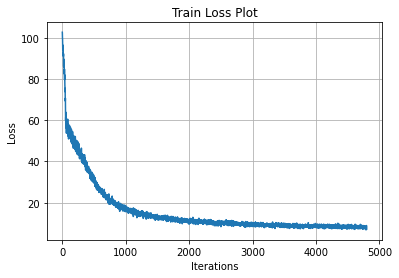

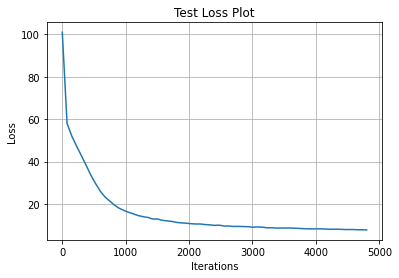

In [ ]:
# Plotting loss vs iterations on Train and Test data for each of the 3 Convolutional AE models
for key in ['c1', 'c2', 'c3']:
    prefix = direc_pics + 'Q6_' + key
    plotGraphs(losses_dict[key], losses_test_dict[key], 75, prefix)

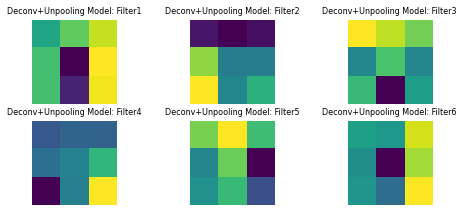

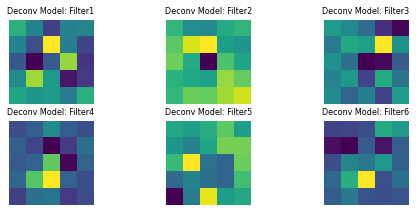

In [ ]:
modelc1 = torch.load(direc_main+'modelc1_final.pth')
modelc2 = torch.load(direc_main+'modelc2_final.pth')
modelc3 = torch.load(direc_main+'modelc3_final.pth')
models = {'c1': modelc1, 'c2': modelc2, 'c3': modelc3}

# Plotting the filters of the 2 models involving Deconv layers alone.
prefix = direc_pics + 'Q6_wt_'

for key in ['c1', 'c3']:
    model = models[key]
    wt = model.state_dict()['deconv1.0.weight']
    cols, rows = 3, 2
    figure = plt.figure(figsize=(8,1.7*rows))
    for i in range(rows*cols):
        figure.add_subplot(rows, cols, i+1)
        plt.title('{} Model: Filter{}'.format('Deconv+Unpooling' if key=='c1' else 'Deconv', i+1), fontsize=8)
        plt.axis("off")
        plt.imshow(torch.squeeze(wt[0,i,:,:]).detach().numpy())

    plt.savefig(prefix + '{}.png'.format(key),bbox_inches='tight')
    plt.show()


# Rough Work

In [ ]:
for i in range(num_epochs):
    print(f"Epoch {i+7}\n-------------------------------")
    train_loop(loaders['train'], model, loss_fn, optimizer)
    test_loop(loaders['test'], model, loss_fn)
print("Done!")

In [ ]:
# class AEsparse(nn.Module):
#     def __init__(self, N=1500):
#         super(AEsparse, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Linear(784, 900), 
#             nn.ReLU(),
#             nn.Linear(900, 1100),  
#             nn.ReLU(),
#             nn.Linear(1100, N), 
#             nn.ReLU()
#         )
#         self.decoder = nn.Sequential(
#             nn.Linear(N, 1100),
#             nn.ReLU(),
#             nn.Linear(1100, 900),
#             nn.ReLU(),
#             nn.Linear(900, 784)
#         )
#         self.relu = nn.Sequential(
#             nn.ReLU()
#         )

#     def forward(self, X, output_active=True):
#         h = self.encoder(X)
#         Xhat = self.decoder(h)
#         if output_active:
#             Xhat = self.relu(Xhat)

#         return {
#             'in': X,
#             'out': Xhat,
#             'h': h
#         }

In [ ]:
print(len(loaders['train']))
print(len(loaders['test']))

for X, y in loaders['train']:
    print(X.shape)
    print(y.shape)
    temp = model(X)
    print(temp['out'].shape)
    print(temp['err'])
    loss = nn.MSELoss(reduction='sum')
    ll = loss(temp['out'], X).item()
    print(ll/10000)
    break

In [ ]:
print(np.min(data['train']['X']))
print(np.min(data_zero['train']['X']))

print(np.max(data['train']['X']))
print(np.max(data_zero['train']['X']))

0.0
-0.5472844
1.0
0.9999162


In [ ]:
print(type(train_data[0]))
print(train_data[0][0].shape)
print(type(train_data[0][1]))

print(train_data.data[0].size())
print(train_data.targets[0])
print(test_data.data.size())
print(test_data.targets.size())

<class 'tuple'>
torch.Size([1, 28, 28])
<class 'int'>
torch.Size([28, 28])
tensor(5)
torch.Size([10000, 28, 28])
torch.Size([10000])


In [ ]:
print(train_data.data[0])

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

In [ ]:
count = 0
for X, y in loaders['test']:
    print(torch.max(X))
    print(torch.min(X))
    count +=1

print(count)

tensor(1.)
tensor(0.)
1


In [ ]:
print(model.state_dict()['conv2.0.weight'][0,0,:,:])
print(model.state_dict()['conv2.0.weight'][1,0,:,:])

tensor([[ 0.1682,  0.0352, -0.0727],
        [ 0.0445,  0.0273,  0.0332],
        [-0.0528,  0.0815,  0.0814]])
tensor([[-0.0973, -0.0522,  0.0827],
        [ 0.0806,  0.1013,  0.0621],
        [-0.0726, -0.0152, -0.0426]])


In [ ]:
for X, y in loaders['test']:
    Xhat = model(X)['out']
    for i in range(5):
        plt.figure()
        plt.imshow(torch.reshape(X[i], (28,28)).detach().numpy())
        plt.figure()
        plt.imshow(torch.reshape(Xhat[i], (28,28)).detach().numpy())
    break

In [ ]:
aa = np.zeros((1,3))
print(len(aa))

In [ ]:
def plotGraphs(losses, losses_test, interval, prefix=''):
    '''
    Function to do all the relevant plotting of loss, accuracy vs iterations
    Arguments:
    losses          List containing loss on the training set every iteration
    losses_test     List containing loss on the test set every 'interval' iterations
    interval        Number of iterations between test set evaluations during training
    prefix          Prefix to be added to plot names when saving     (default: '')
    '''
    # Number of iterations carried out during training
    num_iters = len(losses)

    plt.figure()
    plt.plot(np.arange(num_iters), losses)
    plt.grid()
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Train Loss Plot')
    plt.savefig(prefix + '_train_loss.png',bbox_inches='tight')
    plt.show()

    plt.figure()
    plt.plot(list(np.arange(1, num_iters-1, interval)) + [num_iters], losses_test)
    plt.grid()
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Test Loss Plot')
    plt.savefig(prefix + '_test_loss.png',bbox_inches='tight')
    plt.show()


In [ ]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True         
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

In [ ]:
# Plotting one data point from MNIST
prefix = direc_pics + 'dset_'
plt.imshow(train_data.data[0], cmap='gray')
plt.title('Number %i' % train_data.targets[0])
plt.savefig(prefix + '1point.png', bbox_inches='tight')
plt.show()

In [ ]:
# Plotting 25 random data points from the dataset to get an idea of the dataset
prefix = direc_pics + 'dset_'
figure = plt.figure(figsize=(8, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title('Number {}'.format(label), fontsize=9)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.savefig(prefix + '25point.png',bbox_inches='tight')
plt.show()